In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv('zoo.csv', index_col='animal_name')

In [4]:
df.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
animal_name,,,,,,,,,,,,,,,,,
aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [5]:
X = df.loc[:, 'hair':'catsize']
y = df['class_type']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [7]:
sc = MinMaxScaler().fit(X_train) # scale the data
X_train_std = sc.transform(X_train)
sc1 = MinMaxScaler().fit(X_test)
X_test_std = sc1.transform(X_test)

In [8]:
params = {"n_estimators": [50, 100, 200, 400],
              "max_features": ['log2', 'sqrt'],
              "max_depth": range(3,12),
              "criterion": ["gini", "entropy"],
              "min_samples_split": range(2, 15),
              "class_weight": ['balanced', None]}

In [9]:
model = RandomForestClassifier()
# Instantiate the RandomizedSearchCV object: model_cv
model_cv = RandomizedSearchCV(model, params, n_iter=100, cv=3, scoring='accuracy', random_state = 42)
# Fit it to the data
model_cv.fit(X_train_std, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 7, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score is 0.95


In [10]:
model = RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 4, max_features = 'sqrt',
                               min_samples_split = 7, n_estimators=200)
model.fit(X_train_std, y_train)
y_train_pred = model.predict(X_train_std)
y_pred = model.predict(X_test_std)

In [11]:
confusion = confusion_matrix(y_train, y_train_pred)
confusion

array([[33,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  6,  0],
       [ 0,  0,  0,  0,  0,  0,  8]])

In [12]:
model.score(X_train_std, y_train)

1.0

In [13]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[8, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 2]])

In [14]:
model.score(X_test_std, y_pred)

1.0

Perfect score on the random forest model! Let's look at feature importances.

In [15]:
importances_list = model.feature_importances_

In [19]:
features = X.columns.values

In [40]:
feature_importances = model.feature_importances_ * 100

In [41]:
features = df.columns.values[:-1]

In [35]:
feature_importances_df = pd.DataFrame(data = importances_list * 100, index = features, 
             columns=['Feature Importance']).sort_values(by = 'Feature Importance', ascending = False)

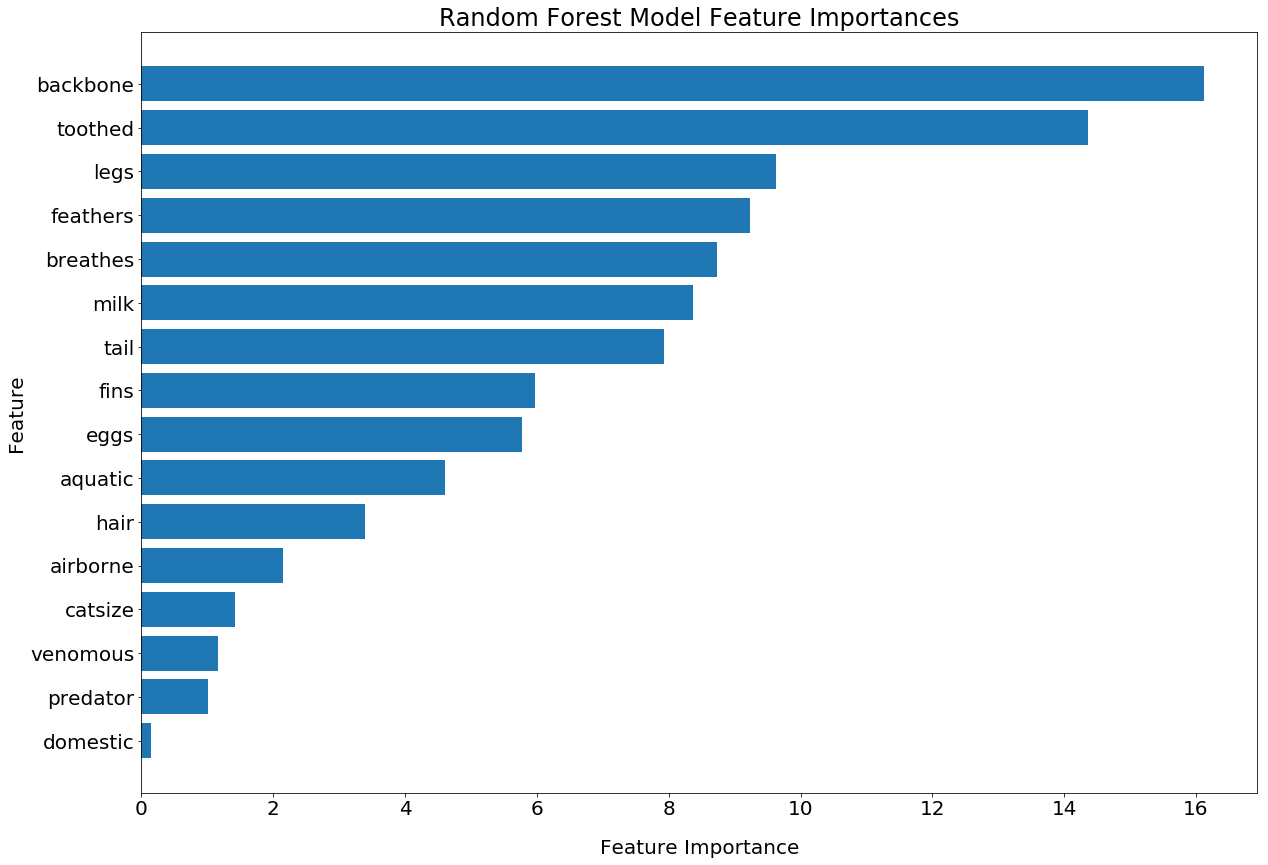

In [37]:
y_pos = np.arange(len(feature_importances_df)) #for specifying the y positions of the bar plot
fig = plt.figure(figsize=(20,14)) #increase graph size
plt.barh(y_pos, np.flipud(feature_importances.loc[:, 'Feature Importance'].values), align='center') #plot the horizontal bars --> position, bar length
plt.xticks(size=20)
plt.yticks(y_pos, np.flipud(feature_importances.index.values), size=20) #plot bar labels
plt.xlabel('Feature Importance', size=20, labelpad=20) #labelpad increases space between xlabel and xaxis
plt.ylabel('Feature', size=20)
plt.title('Random Forest Model Feature Importances', size=24);

In [90]:
feature_importances_df.index.values[:8]

array(['backbone', 'toothed', 'legs', 'feathers', 'breathes', 'milk',
       'tail', 'fins'], dtype=object)

A random forest model was able to obtain perfect accuracy with all 14 features. Can we get perfect accuracy with a simpler model? Let's try building a model with half the features. I'll use the eight features with the highest feature importance values.

In [91]:
features_to_keep = feature_importances_df.index.values[:8]
small_df = df[features_to_keep]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(small_df, y, test_size=0.20, random_state=42, stratify=y)

In [93]:
sc = MinMaxScaler().fit(X_train) # scale the data
X_train_std = sc.transform(X_train)
sc1 = MinMaxScaler().fit(X_test)
X_test_std = sc1.transform(X_test)

In [94]:
params = {"n_estimators": [50, 100, 200, 400],
              "max_features": ['log2', 'sqrt'],
              "max_depth": range(3,12),
              "criterion": ["gini", "entropy"],
              "min_samples_split": range(2, 6),
              "class_weight": ['balanced', None]}

In [95]:
model = RandomForestClassifier()
# Instantiate the RandomizedSearchCV object: model_cv
model_cv = RandomizedSearchCV(model, params, n_iter=100, cv=3, scoring='accuracy', random_state = 42)
# Fit it to the data
model_cv.fit(X_train_std, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 50, 'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced'}
Best score is 0.95


In [96]:
model = RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=10, max_features='sqrt',
                               min_samples_split=3, n_estimators=50)
model.fit(X_train_std, y_train)
y_train_pred = model.predict(X_train_std)
y_pred = model.predict(X_test_std)

In [97]:
confusion = confusion_matrix(y_train, y_train_pred)
confusion

array([[33,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  1,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  6,  0],
       [ 0,  0,  0,  0,  0,  0,  8]])

In [98]:
model.score(X_train_std, y_train)

0.98750000000000004

In [99]:
np.where(y_train != y_train_pred)

(array([76]),)

In [102]:
X_train.iloc[76]

backbone    1
toothed     1
legs        4
feathers    0
breathes    1
milk        0
tail        1
fins        0
Name: newt, dtype: int64

In [123]:
newt = X_train_std[76].reshape(1, -1)
newt

array([[ 1. ,  1. ,  0.5,  0. ,  1. ,  0. ,  1. ,  0. ]])

In [124]:
model.predict(newt)

array([3])

In [125]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[8, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 2]])

In [126]:
model.score(X_test_std, y_test)

1.0

The new model simpler with eight features has 100% accuracy on the testing set but it misclasifies one example from the training set. It predict a newt to be a reptile when it should be an amphibian.

Let's add back in features and see if we can get 100% on the training and testing sets.

In [127]:
features_to_keep = feature_importances_df.index.values[:10]
small_df = df[features_to_keep]

In [128]:
X_train, X_test, y_train, y_test = train_test_split(small_df, y, test_size=0.20, random_state=42, stratify=y)

In [129]:
sc = MinMaxScaler().fit(X_train) # scale the data
X_train_std = sc.transform(X_train)
sc1 = MinMaxScaler().fit(X_test)
X_test_std = sc1.transform(X_test)

In [130]:
params = {"n_estimators": [50, 100, 200, 400],
              "max_features": ['log2', 'sqrt'],
              "max_depth": range(3,12),
              "criterion": ["gini", "entropy"],
              "min_samples_split": range(2, 6),
              "class_weight": ['balanced', None]}

In [131]:
model = RandomForestClassifier()
# Instantiate the RandomizedSearchCV object: model_cv
model_cv = RandomizedSearchCV(model, params, n_iter=100, cv=3, scoring='accuracy', random_state = 42)
# Fit it to the data
model_cv.fit(X_train_std, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'max_features': 'log2', 'max_depth': 11, 'criterion': 'gini', 'class_weight': None}
Best score is 0.95


In [132]:
model = RandomForestClassifier(class_weight=None, criterion='gini', max_depth=11, max_features='log2',
                               min_samples_split=4, n_estimators=200)
model.fit(X_train_std, y_train)
y_train_pred = model.predict(X_train_std)
y_pred = model.predict(X_test_std)

In [133]:
confusion = confusion_matrix(y_train, y_train_pred)
confusion

array([[33,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  6,  0],
       [ 0,  0,  0,  0,  0,  0,  8]])

In [134]:
model.score(X_train_std, y_train)

1.0

In [136]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[8, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 2]])

In [137]:
model.score(X_test_std, y_test)

1.0

In [138]:
importances_list = model.feature_importances_

In [139]:
features = X.columns.values

In [140]:
feature_importances = model.feature_importances_ * 100

In [142]:
features = small_df.columns.values

In [143]:
feature_importances_df = pd.DataFrame(data = importances_list * 100, index = features, 
             columns=['Feature Importance']).sort_values(by = 'Feature Importance', ascending = False)

In [145]:
feature_importances_df

,Feature Importance
milk,20.808360
feathers,14.576144
eggs,13.321050
legs,10.880140
toothed,9.918965
breathes,7.962192
fins,7.271949
backbone,6.946958
tail,4.914991
aquatic,3.399251


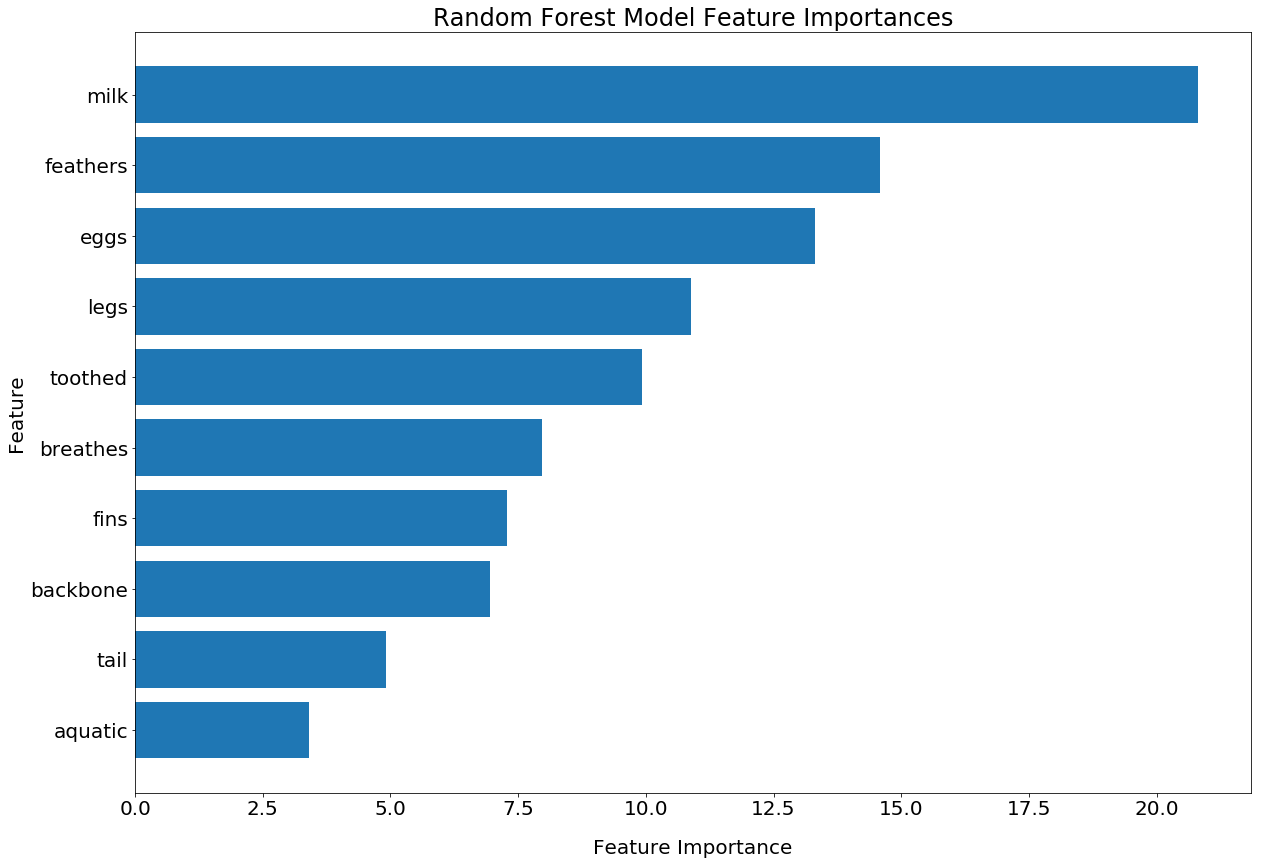

In [147]:
y_pos = np.arange(len(feature_importances_df)) #for specifying the y positions of the bar plot
fig = plt.figure(figsize=(20,14)) #increase graph size
plt.barh(y_pos, np.flipud(feature_importances_df.loc[:, 'Feature Importance'].values), align='center') #plot the horizontal bars --> position, bar length
plt.xticks(size=20)
plt.yticks(y_pos, np.flipud(feature_importances_df.index.values), size=20) #plot bar labels
plt.xlabel('Feature Importance', size=20, labelpad=20) #labelpad increases space between xlabel and xaxis
plt.ylabel('Feature', size=20)
plt.title('Random Forest Model Feature Importances', size=24);

Let's try one last model with nine features

In [156]:
features_to_keep = feature_importances_df.index.values[:9]
small_df = df[features_to_keep]

In [157]:
X_train, X_test, y_train, y_test = train_test_split(small_df, y, test_size=0.20, random_state=42, stratify=y)

In [158]:
sc = MinMaxScaler().fit(X_train) # scale the data
X_train_std = sc.transform(X_train)
sc1 = MinMaxScaler().fit(X_test)
X_test_std = sc1.transform(X_test)

In [159]:
params = {"n_estimators": [50, 100, 200, 400],
              "max_features": ['log2', 'sqrt'],
              "max_depth": range(3,12),
              "criterion": ["gini", "entropy"],
              "min_samples_split": range(2, 6),
              "class_weight": ['balanced', None]}

In [160]:
model = RandomForestClassifier()
# Instantiate the RandomizedSearchCV object: model_cv
model_cv = RandomizedSearchCV(model, params, n_iter=100, cv=3, scoring='accuracy', random_state = 42)
# Fit it to the data
model_cv.fit(X_train_std, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'gini', 'class_weight': 'balanced'}
Best score is 0.9375


In [161]:
model = RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=8, max_features='log2',
                               min_samples_split=5, n_estimators=200)
model.fit(X_train_std, y_train)
y_train_pred = model.predict(X_train_std)
y_pred = model.predict(X_test_std)

In [162]:
confusion = confusion_matrix(y_train, y_train_pred)
confusion

array([[33,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  1,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  6,  0],
       [ 0,  0,  0,  0,  0,  0,  8]])

In [163]:
model.score(X_train_std, y_train)

0.98750000000000004

In [166]:
np.where(y_train != y_train_pred)

(array([23]),)

In [167]:
X_train.iloc[23]

milk        0
feathers    0
eggs        1
legs        4
toothed     1
breathes    1
fins        0
backbone    1
tail        1
Name: tuatara, dtype: int64

In [164]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[8, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 2]])

In [165]:
model.score(X_test_std, y_test)

1.0

The nine feature gets 100% accuracy on the test set but misses one training example. It classifies the tuatara as a lizard when it should be classified as an amphibian.

I'll use the 10 feature random forest model as my final model.  

In [168]:
features_to_keep = feature_importances_df.index.values[:10]
small_df = df[features_to_keep]

In [169]:
X_train, X_test, y_train, y_test = train_test_split(small_df, y, test_size=0.20, random_state=42, stratify=y)

In [170]:
sc = MinMaxScaler().fit(X_train) # scale the data
X_train_std = sc.transform(X_train)
sc1 = MinMaxScaler().fit(X_test)
X_test_std = sc1.transform(X_test)

In [171]:
model = RandomForestClassifier(class_weight=None, criterion='gini', max_depth=11, max_features='log2',
                               min_samples_split=4, n_estimators=200)
model.fit(X_train_std, y_train)
y_train_pred = model.predict(X_train_std)
y_pred = model.predict(X_test_std)

In [172]:
import pickle
filename = 'random_forest_for_dash.sav'
pickle.dump(model, open(filename, 'wb'))

In [174]:
loaded_model = pickle.load(open(filename, 'rb'))
result_train = loaded_model.score(X_train_std, y_train)
result_test = loaded_model.score(X_test_std, y_test)
print(result_train)
print(result_test)

1.0
1.0


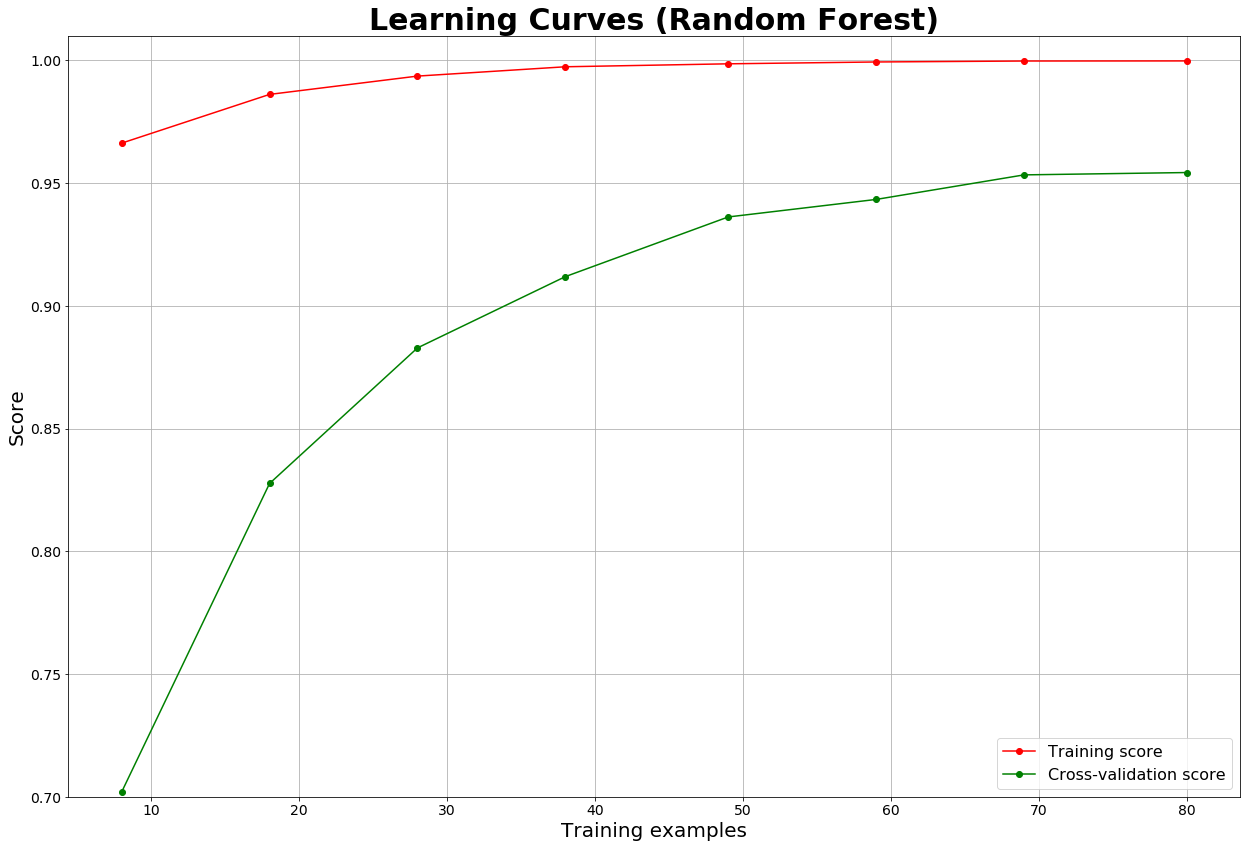

In [175]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize = (21,14))
    plt.title(title, size = 30, weight='bold')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", size = 20)
    plt.ylabel("Score", size = 20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best", prop={'size': 16})
    return plt

X, y = small_df, y

title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(loaded_model, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 8));

The train and test learning curve is close to converging. Ideally, we would collect more data and see these two curves converge.